# Finding flares/outburst through sigma clipping

### TSDA 2020

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import astropy.stats as astats

### Read in the Swift BAT lightcurve of GS 0834-430

In [3]:

colnames = ["mjd", "rate", "raterr", "year", "day", "staterr","syserr", "data_flag", "td", "tc", "tdith"]
lc = pd.read_csv("/Users/vanessa/lecturing/nassp_msc/tsda/data_and_plots/Swift-BAT_GS_0834-430.txt", 
                 delim_whitespace=True, skiprows=5, names=colnames)#, 
#                  dtype ={'mjd': np.float32, 'rate':np.float32, 'mag': np.float32, 'magerr': np.float32,
#                         'fl':str, 'dfl':str})
pd.DataFrame.head(lc)

,mjd,rate,raterr,year,day,staterr,syserr,data_flag,td,tc,tdith
0,56060,-0.000360,0.001506,2012,134,0.001290,-0.000013,0,8224.0,3683.625000,8224.0
1,56062,0.000412,0.001319,2012,136,0.001129,0.000014,0,8712.0,4198.812500,7560.0
2,56063,0.002129,0.001499,2012,137,0.001281,0.000075,0,2632.0,2481.125000,2632.0
3,56064,0.003015,0.002000,2012,138,0.001710,0.000106,0,4672.0,1937.187498,4672.0
4,56065,-0.004483,0.011925,2012,139,0.010209,-0.000157,3,256.0,50.000000,256.0


In [26]:
np.size(lc.mjd)

2784

### Calculate mean, weighted mean and standard deviation

In [5]:
c_mean = lc.rate.mean()
c_var = lc.rate.var()
c_wmean = np.average(lc.rate,weights=1./lc.raterr)
print("Mean: ",c_mean)
print("Weighted mean: ", c_wmean)
print("Sigma: ", math.sqrt(c_var))


Mean:  0.000603792672413793
Weighted mean:  0.00046323571365767277
Sigma:  0.006139214391818538


### Choose a value of $\sigma$ and do the clipping

In this case, we have chosen to clip values $\ge 3\sigma$, but the choice is yours. Well motivated, of course :-)

In [7]:
# Choose sigma, and do the clipping
my_sig = 3.0*math.sqrt(c_var)
print(my_sig)

# Here we generate an array of indices where the count rate is larger than the mean + 3 sigma
idx = np.where(lc.rate>= c_mean + my_sig)
print(idx)

0.018417643175455613
(array([  18,   19,   20,   21,   22,   23,   24,   25,   26,   27,   28,
         29,   30,   31,   32,   33,   34,   35,   36,   37,   38,   39,
         40,   41,   42,   43,   44,   45,   46,   47,   48,   49,   50,
         51,   52,   53,   54,  789,  993, 1195, 2366, 2460, 2462]),)


#### Making some numpy arrays from the pandas DataFrame 
(Not really part of the process - just makes my life easier later on.)

In [ ]:
# Now we make new arrays from the pandas DataFrame
m_mjd =  np.asarray(lc.mjd)
m_rate = np.asarray(lc.rate)
m_err = np.asarray(lc.raterr)

### Plot data, with $3\sigma$ points highlighted in red

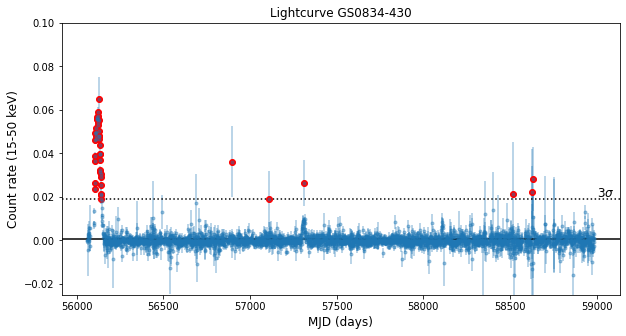

In [14]:
ax = plt.subplots(figsize=(10,5))
plt.errorbar(lc.mjd, lc.rate, lc.raterr, marker='.', alpha=0.4, ls='')
plt.xlabel("MJD (days)",fontsize="12")
plt.ylabel("Count rate (15-50 keV)",fontsize="12")
plt.title('Lightcurve GS0834-430')
plt.ylim([-0.025,0.1])

#plt.axhline(c_mean,color='magenta')
plt.axhline(c_wmean, color='black')
plt.axhline(c_mean + my_sig,color='black', ls=":")


# Overplot the outbursts
plt.plot(m_mjd[idx],m_rate[idx], 'ro')
plt.text(59000,0.02,'3$\sigma$', fontsize=12)

plt.savefig('../data_and_plots/GS0834-430_wmean_3sigma.png')
plt.show()

Ok, we can see this finds the outbursts, but also it misses some of the points which are pretty clearly in the outburst. Can we do better? Maybe don't set our sigma limit, so high. What happens when we choose 3 sigma points?

### Iteration 2 of  weighted mean, and sigma
These points are also dragging up the mean, because they're outbursts. The whole point of this is to remove these and then recalculate.

In [15]:
# qu is what's leftover when I take out the bright points.
qu = np.where(lc.rate < c_wmean + my_sig)

qu_mjd = m_mjd[qu]
qu_rate = m_rate[qu]
qu_err = m_err[qu]

new_mean = qu_rate.mean()
w_mean = np.average(qu_rate,weights=qu_err)
print(new_mean)
print(w_mean)

-2.6060328347318496e-05
-0.00103248951398973


In [16]:
# Choose sigma, and do the clipping

# New variance
n_var = m_rate[qu].var()

my_sig_2 = 3.0*math.sqrt(n_var)
print(my_sig_2)

idx_2 = np.where(m_rate[qu] >= w_mean + my_sig_2)

0.0094329577213543


### Update  the plot to show the additional points that are now identified as bright/outburst points

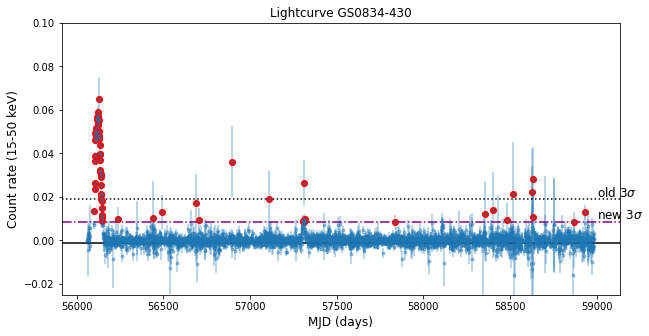

In [20]:
all_idx = np.where(m_rate >= w_mean + my_sig_2)
ax = plt.subplots(figsize=(10,5))
plt.errorbar(lc.mjd, lc.rate, lc.raterr, marker='.', alpha=0.4, ls='')
plt.xlabel("MJD (days)",fontsize="12")
plt.ylabel("Count rate (15-50 keV)",fontsize="12")
plt.title('Lightcurve GS0834-430')
plt.ylim([-0.025,0.1])

plt.axhline(w_mean,color='black')
plt.axhline(c_wmean + my_sig,color='black', ls=":")
plt.axhline(w_mean + my_sig_2,color='purple', ls="-.")

# Overplot the outbursts
plt.plot(m_mjd[all_idx],m_rate[all_idx], 'ro')
plt.text(59000,0.02,'old 3$\sigma$', fontsize=12)
plt.text(59000,0.01,'new 3$\sigma$', fontsize=12)

plt.savefig('../data_and_plots/GS0834-430_3sigma_2nd_iter.png')
plt.show()

Only a few points were add above the 3$\sigma$ limit. Let's iterate yet again.

### 3rd iteration: mean and sigma clippings

In [21]:
# Choose sigma, and do the clipping

# These are the indices where it's quiescent (or not noisy)
qu2 = np.where(lc.rate < w_mean + my_sig_2)

qu2_mjd = m_mjd[qu2]
qu2_rate = m_rate[qu2]
qu2_err = m_err[qu2]


w2_mean = np.average(qu2_rate, weights=qu2_err)
print(new_mean)
print(w2_mean)

# New variance
n2_var = m_rate[qu2].var()

my_sig_3 = 3.0*math.sqrt(n2_var)
print(my_sig_3)

idx_3 = np.where(m_rate[qu2] >= w2_mean + my_sig_3)
print(idx_3)

-2.6060328347318496e-05
-0.0013331579941625472
0.008892926318240587
(array([  16, 1139, 1143, 1863, 1921, 2663]),)


You can see from the size of `idx_3` that this last round didn't get us a whole lot more bright points than we had before. Let's draw the line at this iteration.

### Update the plot below

You can see the current $3\sigma$ line is very close to the new one, no point doing any further iterations.

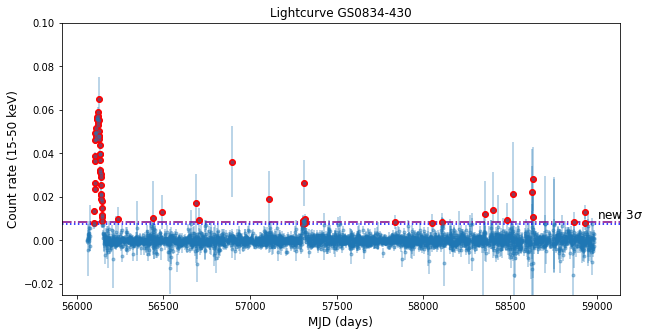

In [23]:
# Now replot, adding these points also to 
all_idx = np.where(m_rate >= w2_mean + my_sig_3)
ax = plt.subplots(figsize=(10,5))
plt.errorbar(lc.mjd, lc.rate, lc.raterr, marker='.', alpha=0.4, ls='')
plt.xlabel("MJD (days)",fontsize="12")
plt.ylabel("Count rate (15-50 keV)",fontsize="12")
plt.title('Lightcurve GS0834-430')
plt.ylim([-0.025,0.1])

#plt.axhline(w_mean,color='magenta')
#plt.axhline(c_mean + my_sig,color='black', ls=":")
plt.axhline(w_mean + my_sig_2,color='purple', ls="-.")
plt.axhline(w2_mean + my_sig_3,color='blue', ls=":")

# Overplot the outbursts
plt.plot(m_mjd[all_idx],m_rate[all_idx], 'ro')
#plt.text(59000,0.02,'old 3$\sigma$', fontsize=12)
plt.text(59000,0.01,'new 3$\sigma$', fontsize=12)

plt.savefig('../data_and_plots/GS0834-430_3rd_iter.png')
plt.show()


### Zoom in on the small outburst
There's clearly an outburst there, but the peak flux has a really large error bar.

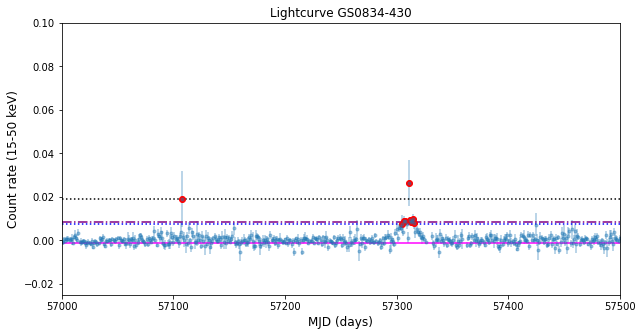

In [29]:
# Now replot, adding these points also to 
all_idx = np.where(m_rate >= w2_mean + my_sig_3)
ax = plt.subplots(figsize=(10,5))
plt.errorbar(lc.mjd, lc.rate, lc.raterr, marker='.', alpha=0.4, ls='')
plt.xlabel("MJD (days)",fontsize="12")
plt.ylabel("Count rate (15-50 keV)",fontsize="12")
plt.title('Lightcurve GS0834-430')
plt.ylim([-0.025,0.1])
plt.xlim([57000,57500])

plt.axhline(w_mean,color='magenta')
plt.axhline(c_mean + my_sig,color='black', ls=":")
plt.axhline(w_mean + my_sig_2,color='purple', ls="-.")
plt.axhline(w2_mean + my_sig_3,color='blue', ls=":")

# Overplot the outbursts
plt.plot(m_mjd[all_idx],m_rate[all_idx], 'ro')

plt.savefig('../data_and_plots/GS0834-430_small_outburst.png')
plt.show()


How does this error bars compare to everything else. Let's make a histogram of the error bars.

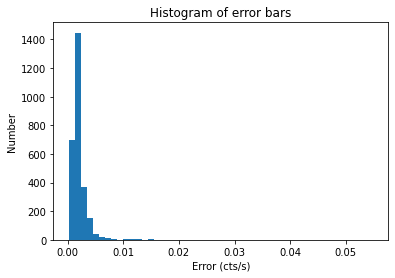

In [31]:
plt.hist(lc.raterr,bins=50)
plt.ylabel("Number")
plt.xlabel("Error (cts/s)")
plt.title("Histogram of error bars")
plt.savefig('../data_and_plots/GS0834-430_histogram_errorbars.png')
plt.show()

From this, it's clear that most points have error bars smaller than 0.005. If we have any peak points with big error bars, then it's a warning signal. Let's see if we have any of those.

In [34]:
bright_mjd = m_mjd[all_idx]
bright_rate = m_rate[all_idx]
bright_err = m_err[all_idx]

idx_bigerr = np.where(bright_err >= 0.01)
print(bright_mjd[idx_bigerr])

[56130 56438 56687 56899 57108 57311 58359 58400 58520 58630 58632 58635]


You can see that we might want to discard quite a few points with error bars larger than 0.01 cts/seconds.


### How do you classify those bright points into distinct outbursts, i.e. are any points next to each other?

Make sure that all bright points are time ordered and try to find an clustering in time.
- For each bright point:

    ** Check if the point after it is also bright
        ---If yes, check the next point too
        ---If no, start a new zone
        

In [108]:
z = np.ravel(all_idx[0]) # Make sure it's a 1D array

i_start = [] # start tme of outburst
i_end = [] # end time of outburst
last = 0
tally =0

for i in z:
    if i > last:
   
        if (i + 1) in z:
            tally = tally + 1
            i = i + 1
            
        else:
            i_end = np.append(i_end,i)
            last = i
            i_start = np.append(i_start,i-tally)
            tally = 0

            
print(i_start)
print(i_end)

[  16.  148.  342.  394.  589.  609.  789.  993. 1189. 1191. 1195. 1709.
 1921. 1979. 2217. 2246. 2329. 2366. 2460. 2462. 2465. 2671. 2729. 2732.]
[  59.  148.  342.  394.  589.  609.  789.  993. 1189. 1192. 1200. 1709.
 1921. 1979. 2217. 2246. 2329. 2366. 2460. 2462. 2465. 2671. 2729. 2732.]


In [95]:
print(np.where((i_end - i_start) > 0))

(array([ 0,  9, 10]),)


From this I can see  that there are only 3 epochs when there is more than 1 consecutive bright points. We have one session of **44 days**, an outburst of **2 days**, and an outburst of **6 days**.

### Let's plot the individual outbursts

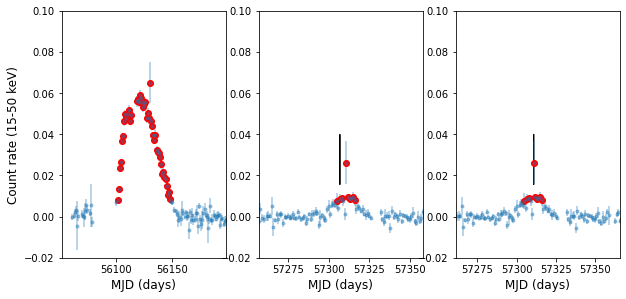

In [107]:
ax = plt.subplots(figsize=(10,10))

# First outburst
plt.subplot(231)
plt.errorbar(lc.mjd, lc.rate, lc.raterr, marker='.', alpha=0.4, ls='')
plt.xlabel("MJD (days)",fontsize="12")
plt.ylabel("Count rate (15-50 keV)",fontsize="12")
plt.xlim([m_mjd[int(i_start[0])] - 50,m_mjd[int(i_end[0])]+50])
plt.ylim([-0.02, 0.1])

plt.plot(m_mjd[all_idx],m_rate[all_idx], 'ro')

# Second outburst
plt.subplot(232)
plt.errorbar(lc.mjd, lc.rate, lc.raterr, marker='.', alpha=0.4, ls='')
plt.xlabel("MJD (days)",fontsize="12")
#plt.ylabel("Count rate (15-50 keV)",fontsize="12")
plt.xlim([m_mjd[int(i_start[9])] - 50,m_mjd[int(i_end[9])]+50])
plt.ylim([-0.02, 0.1])
plt.arrow(m_mjd[int(i_start[9])], 0.04, 0, -0.02)

plt.plot(m_mjd[all_idx],m_rate[all_idx], 'ro')

# Second outburst
plt.subplot(233)
plt.errorbar(lc.mjd, lc.rate, lc.raterr, marker='.', alpha=0.4, ls='')
plt.xlabel("MJD (days)",fontsize="12")
#plt.ylabel("Count rate (15-50 keV)",fontsize="12")
plt.xlim([m_mjd[int(i_start[10])] - 50,m_mjd[int(i_end[10])]+50])
plt.ylim([-0.02, 0.1])
plt.arrow(m_mjd[int(i_start[10])], 0.04, 0, -0.02)

plt.plot(m_mjd[all_idx],m_rate[all_idx], 'ro')

plt.savefig('../data_and_plots/GS0834-430_3zoomed_outbursts.png')
plt.show()

You can see that there are actually only two outbursts, but there have been dips below the $3\sigma$ level during the 2nd outburst, and my algorithm is not smart enough to realize this.

I might think about discarding the bright points with the large error bars.